In [1]:
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit import Chem
from ase.db import connect
from dotenv import load_dotenv
load_dotenv('.env')
db = connect('./test.db')
import os

from calc.call import SubmitTDDFTViaAndromeda
from calc.utils import read_td_dft, rdkit_2_base64png, smiles_2_ase
sub = SubmitTDDFTViaAndromeda(db)
os.getenv('GAUSSIAN_CMD')


'srun -c 64 --mem 160GB --exclusive   -p full_nodes64,partial_nodes,full_nodes48 g16.sh PREFIX.com && echo PREFIX.log '

In [2]:
from rdkit import Chem
from rdkit.Chem import AllChem
from ase.atoms import Atoms
from ase.io import read
import io
from ase.visualize import view
from ase.calculators.gaussian import Gaussian, GaussianOptimizer
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import uuid 
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.molSize = 400,400
def smiles_2_ase(smiles:str)->Atoms:
    a = Chem.MolFromSmiles(smiles)
    a = Chem.AddHs(a)
    AllChem.EmbedMolecule(a)
    AllChem.MMFFOptimizeMolecule(a)
    string = io.StringIO(Chem.MolToXYZBlock(a))
    ase_atoms = read(string,format='xyz')
    return ase_atoms

def quick_view(atoms:Atoms):
    return view(atoms,viewer='ngl')

def opt_pm7(atoms,steps = 1000,method ='PM7'):
    try:
        calc_opt = Gaussian(method=f'{method} NoSymmetry',label = f'tmp/{uuid.uuid4().hex[:6].upper()}')
        opt = GaussianOptimizer(atoms, calc_opt)
        opt.run(steps=steps)
        return atoms
    except Exception:
        return None
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [651]:
r = list(db.select())

In [652]:
reactant = AllChem.MolFromSmiles(r[1].name)
# reactant = mol_with_atom_index(reactant)

In [653]:
reactant = Chem.AddHs(reactant)

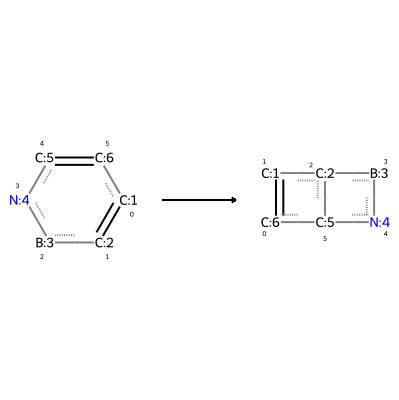

In [654]:
rxn =AllChem.ReactionFromSmarts('[C:1]1=[C:2][B:3][N:4][C:5]=[C:6]1>>[C:6]1=[C:1][C@@:2]2[B:3][N:4][C@@:5]12')
rxn

In [655]:
ps = rxn.RunReactants([reactant])
AllChem.MolToSmiles(ps[0][0])

'[H]C1=C(OC([H])([H])[H])[C@@]2([H])B(OC([H])([H])[H])N([Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[C@@]12[H]'

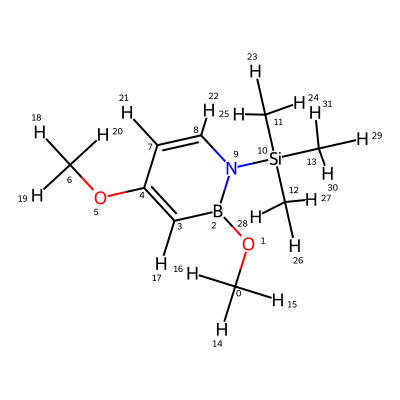

In [656]:
reactant

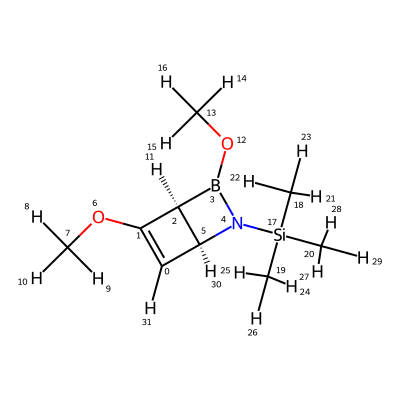

In [657]:
p = ps[0][0]
p

In [658]:
idx_ = [ i.GetPropsAsDict()['react_atom_idx'] for i in p.GetAtoms()]

In [659]:
rev_idx = np.argsort(idx_)

In [660]:
# Chem.SanitizeMol(reactant)
# p = Chem.AddHs(p)
AllChem.EmbedMolecule(reactant)
AllChem.MMFFOptimizeMolecule(reactant)
string = io.StringIO(Chem.MolToXYZBlock(reactant))
r_mol = read(string,format='xyz')

In [661]:
conf = reactant.GetConformer()
init_geom = {}
# Print the 3D coordinates of each atom
for i,atom in enumerate(reactant.GetAtoms()):
    pos = conf.GetAtomPosition(i)
    init_geom.update({rev_idx[i]:pos})

In [662]:
Chem.SanitizeMol(p)
conf = Chem.Conformer(p.GetNumAtoms())
for i in init_geom:
    conf.SetAtomPosition(int(i),init_geom[i])
p.AddConformer(conf)
# AllChem.EmbedMolecule(p,coordMap=init_geom)
# AllChem.EmbedMolecule(p)
AllChem.UFFOptimizeMolecule(p)


1

In [663]:
i

29

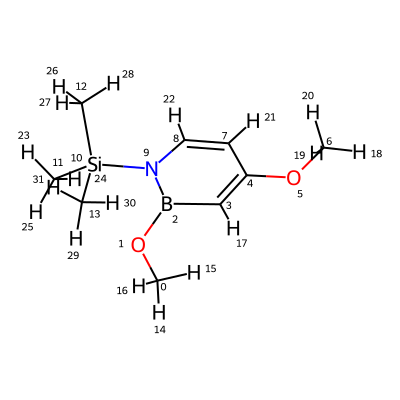

In [664]:
reactant

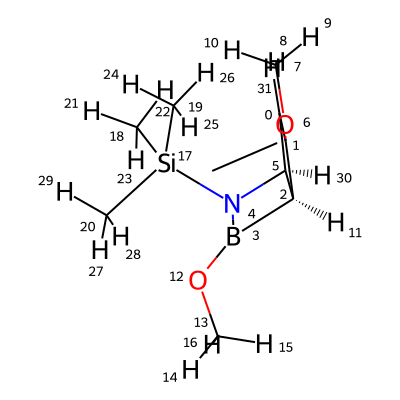

In [668]:
p

In [669]:
string = io.StringIO(Chem.MolToXYZBlock(p))
p_mol = read(string,format='xyz')[rev_idx]

In [670]:
import rmsd
def reorient(A, B):
    A -= rmsd.centroid(A)
    B -= rmsd.centroid(B)
    U = rmsd.kabsch(A, B)
    A = np.dot(A, U)
    return A

In [671]:
A = r_mol.positions
B = p_mol.positions
B = reorient(B,A)

In [672]:
p_mol.positions = B

In [673]:
imgs= [r_mol.copy()]
for i in range(20):
    imgs+= [p_mol.copy()]

In [674]:
from ase.neb import interpolate,idpp_interpolate

In [675]:
interpolate(imgs)

In [676]:
quick_view(imgs)


Note the methyl group and the flip of the ring, it is because the generate 3D geometry does not align with each other when rdkit EmbedMolecule
I reached a dead end, we have two way if we want to keep going:  
 1. permute all atoms and align them
 2. modify 3D coordinates of reactant directly.